In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
import sklearn.metrics
from sklearn.metrics import accuracy_score
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\fedor\anaconda3\envs\ml_basic\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. Загрузка датасета

In [2]:
data = pd.read_csv('../provided_by_the organizers/train_hw.csv', sep=';')

# 2. Обработка данных

### 2.1 Выбор признаков и введение расстояния до центроид кластеров

####  2.1.1 Заполнение пропущенных значений для координат (для кластеризации для импутации даных)

In [3]:
for i in np.unique(data.loc[data['X_LOC'].isna(), 'WELL'].values):
    if np.isnan(data.loc[data['WELL'] == i, 'X_LOC'].mean()) == False:
        data.loc[data['X_LOC'].isna() & (data['WELL'] == i), 'X_LOC'] = data.loc[data['X_LOC'].notna() & (data['WELL'] == i), 'X_LOC'].median()
        data.loc[data['Y_LOC'].isna() & (data['WELL'] == i), 'Y_LOC'] = data.loc[data['Y_LOC'].notna() & (data['WELL'] == i), 'Y_LOC'].median()

####  2.1.2 Кластеризация для импутации данных

In [4]:
kmeans = KMeans(n_clusters=int(len(data['WELL'].unique())/4), random_state=10).fit(data.loc[:, ['X_LOC', 'Y_LOC']])
data.insert(1, "ZONE", kmeans.labels_)

####  2.1.3 Кластеризация и создание дополнительного признака: расстояние до центроиды

In [5]:
kmeans = KMeans(n_clusters=3, random_state=10).fit(data.loc[:, ['X_LOC', 'Y_LOC']])
all_dist = kmeans.transform(data.loc[:, ['X_LOC', 'Y_LOC']])
dist = []
for i, d in enumerate(kmeans.labels_):
    dist.append(all_dist[i][d])
data.insert(1, "Dist_clust_cent", dist)

####  2.1.4 Выделение отдельной скважины для тестирования

In [6]:
data_test = data.loc[data['WELL']=='15/9-13', ['WELL', 'DEPTH_MD', 'Dist_clust_cent', 'DRHO', 'DTC', 'SP', 'GR', 'RDEP', 'FORCE_2020_LITHOFACIES_LITHOLOGY']].dropna()
data = data[data['WELL']!='15/9-13']

####  2.1.5 Создание датасета с отобранными признаками

In [7]:
data_slf = data[['WELL', 'Dist_clust_cent', 'ZONE','FORMATION', 'DEPTH_MD', 'DRHO', 'DTC', 'SP', 'GR', 'RDEP', 'FORCE_2020_LITHOFACIES_LITHOLOGY','FORCE_2020_LITHOFACIES_CONFIDENCE']]

### 2.2 Восстановление (импутация) значений

####  2.2.1 Разбиение на группы по скважинам

In [8]:
gb = data_slf.groupby("WELL")
well_slf_fill_md = [gb.get_group(x) for x in gb.groups]

#### 2.2.2 Импутация значений

In [9]:
d = data_slf.groupby(['FORCE_2020_LITHOFACIES_LITHOLOGY', 'ZONE']).mean()
d_cmn = data_slf.groupby("FORCE_2020_LITHOFACIES_LITHOLOGY").mean()
for i in d_cmn.columns:
    d_cmn[i] = d_cmn[i].fillna(d_cmn[i].mean())
for i in d.columns:
    for j in [30000, 65000, 65030, 70000, 70032, 74000, 80000, 86000, 88000, 90000, 93000, 99000]:
        if np.isnan(d.loc[j, i].median()) == False:
            d[i][j] = d[i][j].fillna(d[i][j].median())
        else:
            d[i][j] = d[i][j].fillna(d_cmn.loc[j, i])

for i in range(len(well_slf_fill_md)):
    values = {'FORMATION': well_slf_fill_md[i]['FORMATION'].mode().iloc[0]}
    well_slf_fill_md[i] = well_slf_fill_md[i].fillna(value=values)
    z = int(np.unique(well_slf_fill_md[i]['ZONE'].values))
    for j in set(well_slf_fill_md[i].columns)-set(['FORCE_2020_LITHOFACIES_CONFIDENCE','FORCE_2020_LITHOFACIES_LITHOLOGY', 'WELL', 'GROUP', 'FORMATION', 'ZONE']):
        if well_slf_fill_md[i][j].isna().sum() != len(well_slf_fill_md[i][j]):
            well_slf_fill_md[i].loc[well_slf_fill_md[i][j].isna(), j] = well_slf_fill_md[i][j].mode().iloc[0]
        else:
            for t in [30000, 65000, 65030, 70000, 70032, 74000, 80000, 86000, 88000, 90000, 93000, 99000]:
                if t in np.unique(well_slf_fill_md[i]['FORCE_2020_LITHOFACIES_LITHOLOGY'].values):
                    if z in d.loc[t, :].index.values:
                        well_slf_fill_md[i].loc[well_slf_fill_md[i]['FORCE_2020_LITHOFACIES_LITHOLOGY'] == t, j]  = d.loc[t, :].loc[z, j]
                    else:
                        m = min(d.loc[t, :].index.values, key=lambda x: abs(x - z))
                        well_slf_fill_md[i].loc[well_slf_fill_md[i]['FORCE_2020_LITHOFACIES_LITHOLOGY'] == t, j] = d.loc[t, :].loc[m, j]

#### 2.2.3 Добавление Гауссовского шума к данным

In [10]:
for i in range(len(well_slf_fill_md)):
    for j in set(well_slf_fill_md[i].columns)-set(['FORCE_2020_LITHOFACIES_CONFIDENCE','FORCE_2020_LITHOFACIES_LITHOLOGY', 'WELL', 'GROUP', 'FORMATION', 'ZONE', 'DEPTH_MD']):
        mu=0.0
        std = 0.15 * np.std(well_slf_fill_md[0].loc[:, j]) #Гауссовский шум %15
        noise = np.random.normal(mu, std, size = well_slf_fill_md[0].loc[:, j].shape[0])
        well_slf_fill_md[0].loc[:, j] = well_slf_fill_md[0].loc[:, j] + noise

#### 2.2.4 Удаление колоноки с зонами для восстановления данных по ближайшим скважинам

In [11]:
for i in range(len(well_slf_fill_md)):
    well_slf_fill_md[i] = well_slf_fill_md[i].drop('ZONE', axis=1, inplace=False)

### 2.3 Подготовка данных к обучению

#### 2.3.1 Скалирование данных

In [12]:
scaler = RobustScaler()
for i in range(len(well_slf_fill_md)):
    well_slf_fill_md[i][['DRHO', 'DTC', 'SP', 'GR', 'RDEP']] = scaler.fit_transform(well_slf_fill_md[i][['DRHO', 'DTC', 'SP', 'GR', 'RDEP']])
data_test[['DRHO', 'DTC', 'SP', 'GR', 'RDEP']] = scaler.fit_transform(data_test[['DRHO', 'DTC', 'SP', 'GR', 'RDEP']])

#### 2.3.2 Объединение индивидуальных скважинных данных

In [13]:
data_slf_fill_md = pd.concat(well_slf_fill_md)

#### 2.3.3 Анализ замеров, для которых литотип предсказан с высокой степенью уверенности

In [14]:
np.unique(data_slf_fill_md[data_slf_fill_md['FORCE_2020_LITHOFACIES_CONFIDENCE']==1]['FORCE_2020_LITHOFACIES_LITHOLOGY'].values)

array([30000, 65000, 65030, 70000, 70032, 74000, 80000, 86000, 88000,
       90000, 93000, 99000], dtype=int64)

#### 2.3.3 Разбиение на тренировочный и тестовый сеты

In [16]:
data_slf_fill_md['FORCE_2020_LITHOFACIES_CONFIDENCE'].dropna(inplace=True)

In [17]:
X_slf_md = data_slf_fill_md.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORMATION'], axis=1)
y_slf_md = data_slf_fill_md['FORCE_2020_LITHOFACIES_LITHOLOGY']
y_test = data_test['FORCE_2020_LITHOFACIES_LITHOLOGY']
data_test.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)

In [18]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

In [19]:
y_slf_md = y_slf_md.map(lithology_numbers)
y_test = y_test.map(lithology_numbers)

In [20]:
y_test = pd.DataFrame(y_test, columns=['FORCE_2020_LITHOFACIES_LITHOLOGY'])
data_test = pd.concat([data_test, y_test], axis=1)

In [21]:
X_train_slf_md, X_test_slf_md, y_train_slf_md, y_test_slf_md = train_test_split(X_slf_md, y_slf_md, train_size=0.80, random_state=42, stratify=y_slf_md)

# 3. Обучение

### 3.1 Подбор гиперпараметров

In [ ]:
def objective_cb(trial):
        X_train, X_test, y_train, y_test = train_test_split(X_train_slf_md, y_train_slf_md, train_size=0.80, random_state=42)
        param = {
            "iterations": 50,
            "loss_function": "MultiClass",
            "task_type": "GPU",
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.8),
            "depth": trial.suggest_int("depth", 5, 16),
            "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
            "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"]),
            'early_stopping_rounds': 20
        }

        cst = CatBoostClassifier(**param)
        cat_features = ['WELL', 'FORMATION']
        cst.fit(X_train, y_train, verbose=False, plot=False, cat_features=cat_features)
        preds = cst.predict(X_test)
        accuracy = sklearn.metrics.accuracy_score(y_test, preds)
        return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_cb, n_trials=1000, timeout=1600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
study.trials_dataframe()

### 3.2 Настройка моделей

In [22]:
param = {
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
    'early_stopping_rounds': 20,
    'task_type': 'GPU',
    'nan_mode': "Forbidden",
    'random_seed': 42,
    'iterations': 500,
    'learning_rate': 0.23714547752509413,
    'depth': 15,
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'Depthwise'
}
    
model_cb = CatBoostClassifier(**param)

In [23]:
weights = []
for i in range(len(y_train_slf_md)):
    weights.append(4-X_train_slf_md['FORCE_2020_LITHOFACIES_CONFIDENCE'].iloc[y_train_slf_md.iloc[i]])

In [24]:
X_train_slf_md.drop('FORCE_2020_LITHOFACIES_CONFIDENCE', axis=1, inplace=True)
X_test_slf_md.drop('FORCE_2020_LITHOFACIES_CONFIDENCE', axis=1, inplace=True)

### 3.3 Обучение моделей

In [25]:
cst = model_cb.fit(X_train_slf_md.drop(['WELL', 'DEPTH_MD'], axis=1), y_train_slf_md, eval_set=(X_test_slf_md.drop(['WELL', 'DEPTH_MD'], axis=1), y_test_slf_md), verbose=False, plot=True, sample_weight=weights)#, cat_features=cat_features)
y_pred_model_cb_slf_md = cst.predict(X_test_slf_md.drop(['WELL', 'DEPTH_MD'], axis=1))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

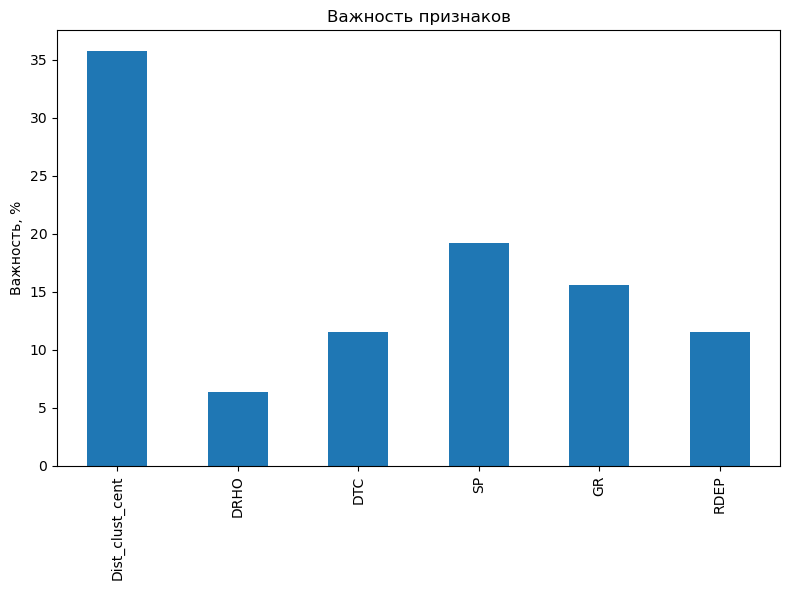

In [26]:
importance = pd.Series(cst.get_feature_importance(),
                         X_train_slf_md.drop(['WELL', 'DEPTH_MD'], axis=1).columns)
fig, ax = plt.subplots(figsize=(8,6))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

# 4. Результаты

### 4.1 Оценка по тестовым данным из всего датасета

In [27]:
A=np.array([[0.    , 2.    , 3.5   , 3.    , 3.75  , 3.5   , 3.5   , 4.    , 4.    , 2.5   , 3.875 , 3.25  ],
            [2.    , 0.    , 2.375 , 2.75  , 4.    , 3.75  , 3.75  , 3.875 , 4.    , 3.    , 3.75  , 3.    ],
            [3.5   , 2.375 , 0.    , 2.    , 3.5   , 3.5   , 3.75  , 4.    , 4.    , 2.75  , 3.25  , 3.    ],
            [3.    , 2.75  , 2.    , 0.    , 2.5   , 2.    , 2.25  , 4.    , 4.    , 3.375 , 3.75  , 3.25  ],
            [3.75  , 4.    , 3.5   , 2.5   , 0.    , 2.625 , 2.875 , 3.75  , 3.25  , 3.    , 4.    , 3.625 ],
            [3.5   , 3.75  , 3.5   , 2.    , 2.625 , 0.    , 1.375 , 4.    , 3.75  , 3.5   , 4.    , 3.625 ],
            [3.5   , 3.75  , 3.75  , 2.25  , 2.875 , 1.375 , 0.    , 4.    , 3.75  , 3.125 , 4.    , 3.75  ],
            [4.    , 3.875 , 4.    , 4.    , 3.75  , 4.    , 4.    , 0.    , 2.75  , 3.75  , 3.75  , 4.    ],
            [4.    , 4.    , 4.    , 4.    , 3.25  , 3.75  , 3.75  , 2.75  , 0.    , 4.    , 4.    , 3.875 ],
            [2.5   , 3.    , 2.75  , 3.375 , 3.    , 3.5   , 3.125 , 3.75  , 4.    , 0.    , 2.5   , 3.25  ],
            [3.875 , 3.75  , 3.25  , 3.75  , 4.    , 4.    , 4.    , 3.75  , 4.    , 2.5   , 0.    , 4.    ],
            [3.25  , 3.    , 3.    , 3.25  , 3.625 , 3.625 , 3.75  , 4.    , 3.875 , 3.25  , 4.    , 0.    ]])

In [28]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [29]:
print(f'Result (CatBoost): {score(y_test_slf_md.values, y_pred_model_cb_slf_md)}')
print(f'Accuracy (CatBoost): {sklearn.metrics.accuracy_score(y_test_slf_md.values, y_pred_model_cb_slf_md)}')

Result (CatBoost): [-0.17899947]
Accuracy (CatBoost): 0.9340504840550404


### 4.2 Оценка по отложенной скважине

In [30]:
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D', '#f5fffa', '#fff5ee', '#ffdab9']

facies_labels = ['Sandstone', 'Sandstone/Shale', 'Shale', 'Marl', 'Dolomite',
                 'Limestone', 'Chalk', 'Halite', 'Anhydrite', 'Tuff', 'Coal', 'Basement']

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

In [31]:
y = pd.DataFrame(cst.predict(data_test.drop(['WELL', 'DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=False)), columns=['FORCE_2020_LITHOFACIES_LITHOLOGY'])

In [32]:
data_pred = pd.concat([data_test.loc[:, 'DEPTH_MD'], y], axis=1)

In [33]:
def make_facies_log_plot(logs, logs_pred, facies_colors):
    #кривые должны быть отсортированы по глубине
    #logs = data[data['WELL']=='15/9-13'].sort_values(by='DEPTH_MD')
    #logs.loc[:, 'FORCE_2020_LITHOFACIES_LITHOLOGY'] = logs.loc[:, 'FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)
    logs = logs.sort_values(by='DEPTH_MD')
    logs_pred = logs_pred.sort_values(by='DEPTH_MD')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    
    cluster=np.repeat(np.expand_dims(logs['FORCE_2020_LITHOFACIES_LITHOLOGY'].values,1), 100, 1)
    cluster_pred=np.repeat(np.expand_dims(logs_pred['FORCE_2020_LITHOFACIES_LITHOLOGY'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(8, 12))
    ax[0].plot(logs.DRHO, logs.DEPTH_MD, '-g')
    ax[1].plot(logs.DTC, logs.DEPTH_MD, '-')
    ax[2].plot(logs.SP, logs.DEPTH_MD, '-', color='0.5')
    ax[3].plot(logs.GR, logs.DEPTH_MD, '-', color='r')
    ax[4].plot(logs.RDEP, logs.DEPTH_MD, '-', color='black')
    ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=12)
    im=ax[6].imshow(cluster_pred, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=12)
    
    make_axes_locatable(ax[5])
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((11*' ').join(['SS', 'SS/Shl', 'Shl', 'Mrl', 'Dlm',
                 'Lmst', 'Chlk', 'Hlt', 'Anhdr', 'Tff', 'Cl', 'Bsmnt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("DRHO")
    ax[0].set_xlim(logs.DRHO.min(),logs.DRHO.max())
    ax[1].set_xlabel("DTC")
    ax[1].set_xlim(logs.DTC.min(),logs.DTC.max())
    ax[2].set_xlabel("SP")
    ax[2].set_xlim(logs.SP.min(),logs.SP.max())
    ax[3].set_xlabel("GR")
    ax[3].set_xlim(logs.GR.min(),logs.GR.max())
    ax[4].set_xlabel("RDEP")
    ax[4].set_xlim(logs.RDEP.min(),logs.RDEP.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel('Facies_pred')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['WELL'], fontsize=14,y=0.94)

In [34]:
print('Accuracy (WELL 15/9-13):')
print(sklearn.metrics.accuracy_score(y_test.values, cst.predict(data_test.drop(['WELL', 'DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=False))))

Accuracy (WELL 15/9-13):
0.7463301995711694


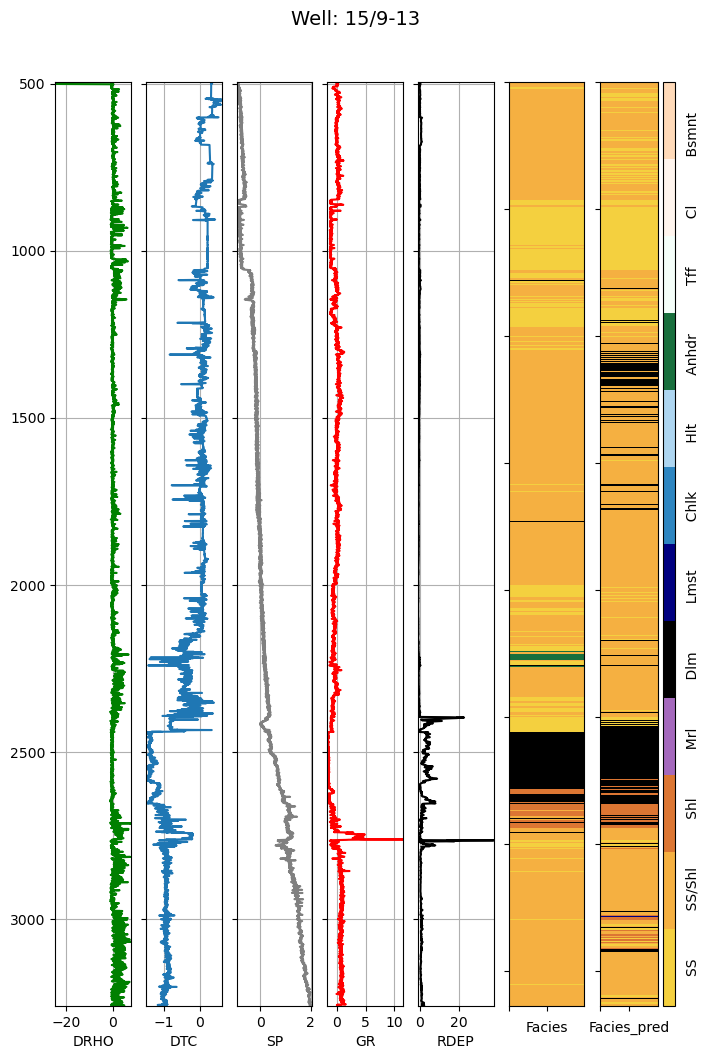

In [35]:
make_facies_log_plot(
    data_test, 
    data_pred,
    facies_colors=facies_colors)